## Habitat Classification 

Based on the opportunity polygons from MHC and the current LC data predcition

In [30]:
import os
import shutil
import rasterio
import re
import geopandas as gpd
import numpy as np
import json
import random
from rasterio.mask import mask
from glob import glob
from shapely.geometry import Point, Polygon, box
from rasterio.features import rasterize
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


In [11]:
# File Paths
raster_path = "../data/tif/SK0858_combined.tif"
shapefile_path = "../data/boundaries/MHC_Utopia_Stage_2/MHC_Utopia_Stage_2.shp"
json_path = "updated_habitat_codes.json"  # Habitat classification file
output_raster_path = "../data/tif/updated_SK0858.tif"

In [13]:
# Set correct CRS (EPSG 27700 - British National Grid)
target_crs = "EPSG:27700"

# Load habitat classification dictionary
with open(json_path, "r") as file:
    habitat_dict = json.load(file)["habitat_codes"]

# Load raster and get CRS
with rasterio.open(raster_path) as src:
    land_cover = src.read(1)  # Read the first band
    profile = src.profile
    raster_bounds = src.bounds
    raster_crs = src.crs  # Get CRS from raster
    transform = src.transform

# Load shapefile
habitats = gpd.read_file(shapefile_path)

# Check if the CRS needs to be fixed
if habitats.crs is None:
    print("⚠ Warning: Shapefile has no CRS! Setting to EPSG:27700.")
    habitats.set_crs(target_crs, inplace=True)
elif habitats.crs != target_crs:
    print(f"⚠ Warning: Shapefile CRS ({habitats.crs}) does not match EPSG:27700. Reprojecting...")
    habitats = habitats.to_crs(target_crs)

# Print dataset summary
print("Raster CRS:", raster_crs)
print("Shapefile CRS:", habitats.crs)
print("Raster unique values:", np.unique(land_cover))
print("Shapefile columns:", habitats.columns)
print("Unique values in 'utopiaphas':", habitats["utopiaphas"].unique())


⚠ Warning: Shapefile CRS (EPSG:3857) does not match EPSG:27700. Reprojecting...
Raster CRS: EPSG:27700
Shapefile CRS: EPSG:27700
Raster unique values: [101 102 103 104 201 202 203 204 302 303 403 404 409 410 411 504]
Shapefile columns: Index(['land_manag', 'mhc_id', 'currentpha', 'utopiaphas', 'notes',
       'interventi', 'interven_1', 'interven_2', 'utopiaukha', 'utopiauk_1',
       'SHAPE__Len', 'SHAPE__Are', 'hectares', 'geometry'],
      dtype='object')
Unique values in 'utopiaphas': ['MARSHY /ACID /NEUTRAL  -MOSAIC SPECIES RICH GRASSLANDS' 'WOOD PASTURE'
 'BROADLEAVED WOODLAND' 'SPECIES RICH GRASSLAND SCRUB MOSAIC'
 'DRY HEATH WITH SCATTERED SCRUB WOODY MOSAICS'
 'BROADLEAVED WOODLAND SCATTERED SCRUB' 'BROADLEAVED WOODLAND & SCRUB'
 'DRY HEATH' 'WET WOODLAND' 'FLUSH' 'WET HEATH' 'BLANKET BOG'
 'BROADLEAVED/WET WOODLAND' 'CLOUGH WOODLAND' 'ACID GRASSLAND'
 'BLANKET BOG WITH SCATTERED SCRUB WOODY MOSAICS' 'WILLOW SCRUB'
 'ACID GRASSLAND & SCATTERED GORSE SCRUB MOSAIC' 'SCRUB WOODLA

In [7]:
# Clean and standardize habitat names - this is a nightmare bad data management!!
def clean_habitat_name(name):
    name = str(name).strip().upper()
    name = name.replace("MOSIAC", "MOSAIC")  # Fix typos
    name = re.sub(r"\s{2,}", " ", name)  # Remove extra spaces
    name = re.sub(r"\s*-\s*", "-", name)  # Standardize hyphens
    name = re.sub(r"\s*/\s*", "/", name)  # Standardize slashes
    return name

# Extract unique cleaned habitat names
unique_habitats = sorted(set(habitats["utopiaphas"].apply(clean_habitat_name)))

# Create a default JSON dictionary structure
new_habitat_dict = {hab: {"type": "ignore", "density": 0} for hab in unique_habitats}

# Save to a new JSON file
json_path = "new_habitat_codes.json"
with open(json_path, "w") as json_file:
    json.dump({"habitat_codes": new_habitat_dict}, json_file, indent=4)

print(f"New habitat_codes.json created at: {json_path}")

New habitat_codes.json created at: new_habitat_codes.json


In [8]:
from shapely.geometry import box

# Create a bounding box from the raster bounds
raster_bbox = box(*raster_bounds)

# Clip the habitat polygons to exactly fit the raster extent
habitats_filtered = habitats[habitats.intersects(raster_bbox)]

# Debug: Check new bounds
print(f"Raster Bounds: {raster_bounds}")
print(f"Filtered Habitat Bounds: {habitats_filtered.total_bounds}")


Raster Bounds: BoundingBox(left=408000.0, bottom=358000.0, right=409000.0, top=359000.0)
Filtered Habitat Bounds: [407619.06876586 357620.67787839 409453.23045198 359696.34746899]


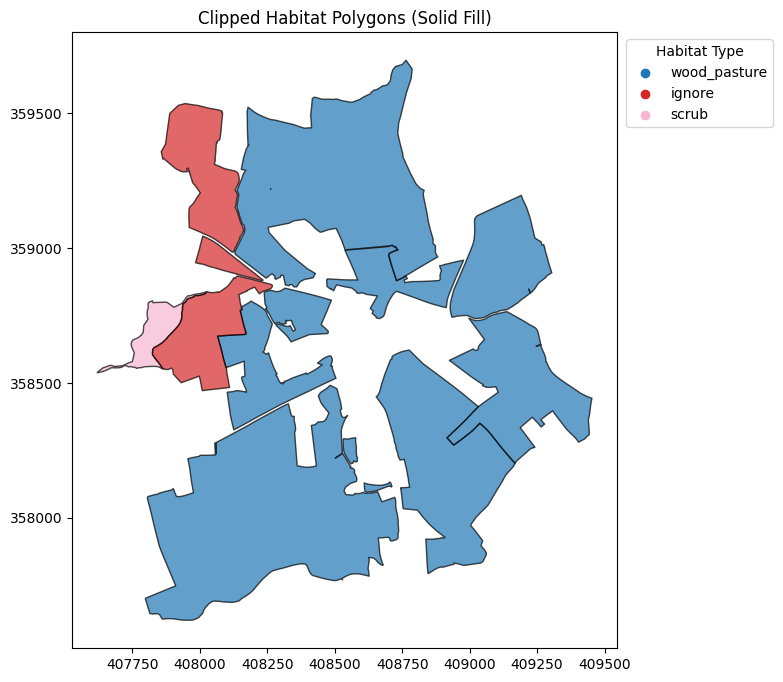

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create a color map for habitat types
unique_habitats = habitats_filtered["type"].unique()
color_map = {hab: mcolors.to_hex(plt.cm.tab20(i / len(unique_habitats))) for i, hab in enumerate(unique_habitats)}

# Plot the filtered habitat polygons with solid colors
fig, ax = plt.subplots(figsize=(8, 8))
habitats_filtered.plot(ax=ax, color=[color_map[hab] for hab in habitats_filtered["type"]], edgecolor="black", alpha=0.7)

# Add legend
for hab, color in color_map.items():
    ax.scatter([], [], color=color, label=hab)

ax.legend(title="Habitat Type", loc="upper right", bbox_to_anchor=(1.3, 1))
ax.set_title("Clipped Habitat Polygons (Solid Fill)")
plt.show()


In [14]:
# Function to classify habitats based on the JSON structure
def classify_habitat(row):
    habitat_name = str(row["utopiaphas"]).strip().upper()  # Normalize case

    # Default values if habitat is not found in JSON
    if habitat_name not in habitat_dict:
        print(f"⚠ Warning: Habitat '{habitat_name}' not found in habitat_codes.json")
        return [["ignore"], [0]]  # Ensuring it returns lists

    # Return the types and densities from the JSON
    return [habitat_dict[habitat_name]["types"], habitat_dict[habitat_name]["densities"]]

# Apply classification function
habitats_filtered[["types", "densities"]] = habitats_filtered.apply(
    classify_habitat, axis=1, result_type="expand"
)

⚠ Warning: Habitat 'MARSHY /ACID /NEUTRAL  -MOSAIC SPECIES RICH GRASSLANDS' not found in habitat_codes.json
⚠ Warning: Habitat 'MARSHY /ACID /NEUTRAL  -MOSAIC SPECIES RICH GRASSLANDS' not found in habitat_codes.json
⚠ Warning: Habitat 'MARSHY /ACID /NEUTRAL  -MOSAIC SPECIES RICH GRASSLANDS' not found in habitat_codes.json


In [15]:
print(habitats_filtered[["utopiaphas", "types", "densities"]].head())


                                           utopiaphas     types densities
1                                        WOOD PASTURE   [trees]       [8]
16                                       WOOD PASTURE   [trees]       [8]
17  MARSHY /ACID /NEUTRAL  -MOSAIC SPECIES RICH GR...  [ignore]       [0]
55                                       WOOD PASTURE   [trees]       [8]
56                                       WOOD PASTURE   [trees]       [8]


In [16]:
# Function to generate scrub and mixed scrub/tree patches
def generate_scrub_patches(polygon, scrub_density, tree_density, patch_size_range=(5, 50)):
    """Generate scrub patches (and trees if applicable) inside a polygon."""
    num_scrub_patches = int(scrub_density * 2)  # Adjust scrub density scaling
    num_tree_patches = int(tree_density * 2) if tree_density > 0 else 0  # Trees only if specified
    
    minx, miny, maxx, maxy = polygon.bounds
    patches = []

    # Generate scrub patches
    for _ in range(num_scrub_patches):
        patch_size = random.randint(*patch_size_range)
        x, y = random.uniform(minx, maxx), random.uniform(miny, maxy)
        point = Point(x, y)

        if polygon.contains(point):
            buffer_size = np.sqrt(patch_size) * 0.5
            patch = point.buffer(buffer_size)
            patches.append((patch, 103))  # Scrub class (103)

    # Generate tree patches if applicable
    for _ in range(num_tree_patches):
        x, y = random.uniform(minx, maxx), random.uniform(miny, maxy)
        point = Point(x, y)

        if polygon.contains(point):
            buffer_size = 6.25  # Tree crowns ~100m²
            patch = point.buffer(buffer_size)
            patches.append((patch, 101))  # Tree class (101)

    return patches

# Generate scrub patches for habitats that include scrub and possibly trees
scrub_patches = []
for _, row in habitats_filtered.iterrows():
    if "scrub" in row["types"]:
        scrub_density = row["densities"][row["types"].index("scrub")]
        tree_density = row["densities"][row["types"].index("trees")] if "trees" in row["types"] else 0
        patches = generate_scrub_patches(row.geometry, scrub_density, tree_density)
        scrub_patches.extend(patches)

# Rasterize scrub patches
scrub_raster = rasterize(
    scrub_patches,
    out_shape=land_cover.shape,
    transform=profile["transform"]
)

# Apply scrub patches to raster (only add scrub where empty)
land_cover[(scrub_raster == 103) & (land_cover == 0)] = 103
land_cover[(scrub_raster == 101) & (land_cover == 0)] = 101  # Add trees only in empty areas

print("Scrub patches (with trees where applicable) added to raster.")


Scrub patches (with trees where applicable) added to raster.


In [17]:
# Function to generate tree crowns as clusters
def generate_wood_pasture_trees(polygon, tree_density, scrub_density):
    """Generate tree crowns inside wood pasture polygons, adding scrub where relevant."""
    num_trees = int(tree_density * 250)  # Adjust tree density scaling
    num_scrubs = int(scrub_density * 100) if scrub_density > 0 else 0  # Add scrub if applicable

    minx, miny, maxx, maxy = polygon.bounds
    tree_patches = []

    # Generate tree clusters
    for _ in range(num_trees):
        x, y = np.random.uniform(minx, maxx), np.random.uniform(miny, maxy)
        point = Point(x, y)

        if polygon.contains(point):
            tree_cluster = point.buffer(6.25)  # Approximate ~100m² tree crown
            tree_patches.append((tree_cluster, 101))  # Trees (101)

    # Generate scrub in wood pasture if applicable
    for _ in range(num_scrubs):
        x, y = np.random.uniform(minx, maxx), np.random.uniform(miny, maxy)
        point = Point(x, y)

        if polygon.contains(point):
            scrub_patch = point.buffer(5)  # Small scrub patch
            tree_patches.append((scrub_patch, 103))  # Scrub (103)

    return tree_patches

# Generate tree crowns for wood pasture polygons (and scrub where applicable)
wood_pasture_patches = []
for _, row in habitats_filtered.iterrows():
    if "trees" in row["types"]:
        tree_density = row["densities"][row["types"].index("trees")]
        scrub_density = row["densities"][row["types"].index("scrub")] if "scrub" in row["types"] else 0
        tree_clusters = generate_wood_pasture_trees(row.geometry, tree_density, scrub_density)
        wood_pasture_patches.extend(tree_clusters)

# Rasterize tree crown patches
wood_pasture_raster = rasterize(
    wood_pasture_patches,
    out_shape=land_cover.shape,
    transform=profile["transform"]
)

# Convert more land cover types to trees and scrub
valid_conversion_classes = [302, 303, 202, 204]  # Grasslands + Upland + Mosaic
for code in valid_conversion_classes:
    land_cover[(wood_pasture_raster == 101) & (land_cover == code)] = 101  # Trees
    land_cover[(wood_pasture_raster == 103) & (land_cover == code)] = 103  # Scrub

print("Larger tree crowns (with scrub where applicable) added in wood pasture areas!")

Larger tree crowns (with scrub where applicable) added in wood pasture areas!


In [18]:
# Save the updated raster
with rasterio.open(output_raster_path, "w", **profile) as dst:
    dst.write(land_cover, 1)

print(f"Updated raster saved: {output_raster_path}")

Updated raster saved: ../data/tif/updated_SK0858.tif


# Plot the data

In [19]:
# File paths
original_pred_path = "../data/tif/SK0858_combined.tif"
raw_imagery_path = "../data/tif/SK0858.tif"
updated_habitat_path = "../data/tif/updated_SK0858.tif"

In [20]:
# Function to load raster data
def load_raster(filepath, rgb=False):
    with rasterio.open(filepath) as src:
        if rgb:
            return src.read([1, 2, 3]).transpose(1, 2, 0)  # Load RGB as (H, W, 3)
        return src.read(1)  # Load single-band raster

# Load rasters
original_pred = load_raster(original_pred_path)
raw_imagery = load_raster(raw_imagery_path, rgb=True)  # Load as RGB
updated_habitat = load_raster(updated_habitat_path)

# Load raster metadata to define clipping area
with rasterio.open(updated_habitat_path) as src:
    raster_bounds = src.bounds  # Get raster extent

# Clip the shapefile to the raster bounds
habitats_filtered = habitats.cx[raster_bounds.left:raster_bounds.right, raster_bounds.bottom:raster_bounds.top]

# Print raster and shapefile info
print(f"Original Predictions Shape: {original_pred.shape}")
print(f"Raw Imagery Shape (RGB): {raw_imagery.shape}")
print(f"Updated Habitat Shape: {updated_habitat.shape}")
print(f"Clipped Shapefile CRS: {habitats_filtered.crs}, Number of Features: {len(habitats_filtered)}")


Original Predictions Shape: (8000, 8000)
Raw Imagery Shape (RGB): (8000, 8000, 3)
Updated Habitat Shape: (8000, 8000)
Clipped Shapefile CRS: EPSG:27700, Number of Features: 14


In [21]:
# Land cover color mapping
class_colors_combined = {
    0: '#D3D3D3',  # No Class (Light grey)
    101: '#006400',  # Broadleaved Woodland (Dark green)
    102: '#008000',  # Coniferous Woodland (Green)
    103: '#808000',  # Scrub (Olive)
    104: '#A52A2A',  # Felled/Young Trees (Brown)
    201: '#800080',  # Heather Moorland (Purple)
    202: '#DDA0DD',  # Upland Grass Moor (Plum)
    203: '#FFFF00',  # Bracken (Yellow)
    204: '#FFD700',  # Mosaic (Gold)
    504: '#FF0000',  # Rush Pasture (Red)
    302: '#90EE90',  # Improved Grassland (Light green)
    303: '#32CD32',  # Rough Grassland (Lime green)
    401: '#0000FF',  # River (Blue)
    402: '#00FFFF',  # Lake (Cyan)
    403: '#ADD8E6',  # Pond (Light blue)
    404: '#808080',  # Suburban (Grey)
    405: '#808080',  # Cemeteries (Grey)
    406: '#90EE90',  # Playing Fields (Light green)
    407: '#000000',  # Railway Verges (Black)
    408: '#000000',  # Railway (Black)
    409: '#000000',  # Road (Black)
    410: '#808080',  # Road Verges (Grey)
    411: '#000000',  # Dense Urban (Black)
    205: '#FF00FF',  # Heather Moorland on blanket bog/deep peat (Magenta)
    206: '#FF1493',  # Upland Grass Moor on blanket bog/deep peat (Deep pink)
    207: '#FF69B4'   # Mosaic on blanket bog/deep peat (Hot pink)
}

# Convert hex colors to RGB (0-1 range for matplotlib)
land_cover_cmap = mcolors.ListedColormap([mcolors.hex2color(class_colors_combined[val]) for val in sorted(class_colors_combined.keys())])
land_cover_norm = mcolors.BoundaryNorm(sorted(class_colors_combined.keys()), land_cover_cmap.N)


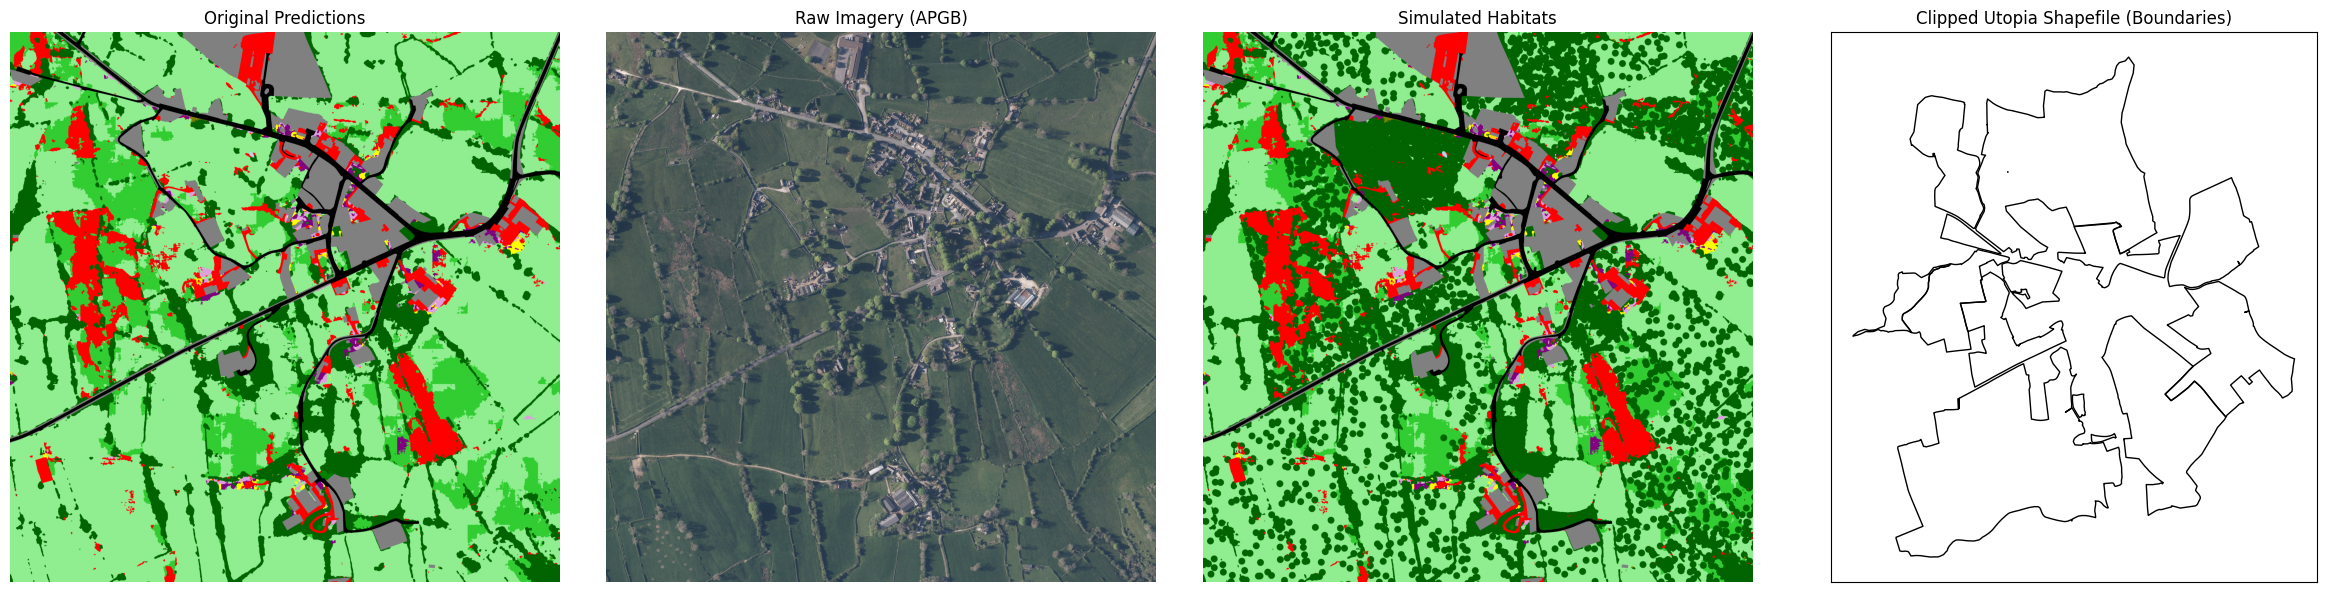

In [22]:
# Define figure size
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# Plot Original Predictions (Land Cover)
im1 = axes[0].imshow(original_pred, cmap=land_cover_cmap, norm=land_cover_norm)
axes[0].set_title("Original Predictions")
axes[0].axis("off")

# Plot Raw Imagery (Center) as RGB
axes[1].imshow(raw_imagery)
axes[1].set_title("Raw Imagery (APGB)")
axes[1].axis("off")

# Plot Updated Habitat Map (Simulated Changes)
im3 = axes[2].imshow(updated_habitat, cmap=land_cover_cmap, norm=land_cover_norm)
axes[2].set_title("Simulated Habitats")
axes[2].axis("off")

# Plot Clipped Habitat Shapefile
habitats_filtered.plot(ax=axes[3], edgecolor="black", facecolor="none", linewidth=1)
axes[3].set_title("Clipped Utopia Shapefile (Boundaries)")
axes[3].set_xticks([])
axes[3].set_yticks([])

# Show the plot
plt.tight_layout()
plt.show()


In [23]:
import numpy as np

# Check if any new 103 (Scrub) or 101 (Trees) pixels were added
scrub_diff = np.sum(updated_habitat == 103) - np.sum(original_pred == 103)
wood_pasture_diff = np.sum(updated_habitat == 101) - np.sum(original_pred == 101)

print(f"New Scrub Pixels Added: {scrub_diff}")
print(f"New Wood Pasture Pixels Added: {wood_pasture_diff}")

# If both values are 0, then no new patches were actually added!


New Scrub Pixels Added: 0
New Wood Pasture Pixels Added: 13280297


# Batch this! 

In [ ]:
# Select the 1km tifs that intersect with the habitat polygons (UTOPIA)

# File paths
shapefile_path = "../data/boundaries/MHC_Utopia_Stage_2/MHC_Utopia_Stage_2.shp"
grid_path = "../data/boundaries/morridge_grid/morr_OS_bng_grid_1km.shp"

# Load the habitat shapefile
habitats = gpd.read_file(shapefile_path)

# Load the 1km grid shapefile
grid = gpd.read_file(grid_path)

# Ensure both layers have the same CRS
if habitats.crs != grid.crs:
    print(f"⚠ CRS mismatch! Reprojecting grid from {grid.crs} to {habitats.crs}")
    grid = grid.to_crs(habitats.crs)

# Find grid tiles that intersect with the habitat polygons
intersecting_tiles = grid[grid.intersects(habitats.unary_union)]

# Extract the tile names
tile_names = intersecting_tiles["tile_name"].unique().tolist()

# Print results
print(f"{len(tile_names)} tiles intersect with the habitat polygons.")
print("Tile Names:", tile_names)

⚠ CRS mismatch! Reprojecting grid from EPSG:27700 to EPSG:3857


/tmp/ipykernel_5604/1514805240.py:17: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  intersecting_tiles = grid[grid.intersects(habitats.unary_union)]


87 tiles intersect with the habitat polygons.
Tile Names: ['SJ9660', 'SJ9661', 'SJ9662', 'SJ9664', 'SJ9665', 'SJ9760', 'SJ9761', 'SJ9762', 'SJ9765', 'SJ9766', 'SJ9864', 'SJ9865', 'SJ9866', 'SJ9962', 'SJ9963', 'SJ9964', 'SJ9965', 'SJ9966', 'SK0061', 'SK0062', 'SK0063', 'SK0064', 'SK0065', 'SK0066', 'SK0068', 'SK0160', 'SK0161', 'SK0162', 'SK0163', 'SK0164', 'SK0165', 'SK0166', 'SK0167', 'SK0168', 'SK0169', 'SK0260', 'SK0261', 'SK0262', 'SK0263', 'SK0264', 'SK0265', 'SK0267', 'SK0268', 'SK0269', 'SK0360', 'SK0361', 'SK0362', 'SK0363', 'SK0364', 'SK0365', 'SK0366', 'SK0367', 'SK0368', 'SK0460', 'SK0461', 'SK0462', 'SK0463', 'SK0465', 'SK0466', 'SK0467', 'SK0559', 'SK0560', 'SK0561', 'SK0562', 'SK0563', 'SK0659', 'SK0660', 'SK0661', 'SK0662', 'SK0757', 'SK0758', 'SK0759', 'SK0760', 'SK0761', 'SK0857', 'SK0858', 'SK0859', 'SK0860', 'SK0861', 'SK0862', 'SK0957', 'SK0958', 'SK0959', 'SK0960', 'SK0961', 'SK1058', 'SK1059']


In [31]:
# select the matching tifs

# File paths
source_folder = "/home/david/Documents/Eco/predictions/dissolved_output_with_soils"
destination_folder = "../data/Land-Cover"

# Ensure destination folder exists
os.makedirs(destination_folder, exist_ok=True)

# Get a list of all TIF files in the source folder
all_tifs = glob(os.path.join(source_folder, "*_combined.tif"))

# Extract tile names from filenames
matching_tifs = [tif for tif in all_tifs if os.path.basename(tif).split("_combined.tif")[0] in tile_names]

# Copy matching files
for tif in matching_tifs:
    shutil.copy(tif, destination_folder)

print(f"{len(matching_tifs)} TIF files copied to {destination_folder}.")

87 TIF files copied to ../data/Land-Cover.


In [11]:
import os
import json
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from shapely.geometry import box, Point
import random
from glob import glob
import matplotlib.pyplot as plt

# File Paths
raster_folder = "../data/Land-Cover"
shapefile_path = "../data/boundaries/MHC_Utopia_Stage_2/MHC_Utopia_Stage_2.shp"
json_path = "updated_habitat_codes.json"
output_folder = "../data/Land-Cover-Predicted"

# Ensure output folder exists
os.makedirs(output_folder, exist_ok=True)

# Load habitat classification dictionary
with open(json_path, "r") as file:
    habitat_dict = json.load(file)["habitat_codes"]

# Load shapefile
habitats = gpd.read_file(shapefile_path)

# Set correct CRS (EPSG 27700 - British National Grid)
target_crs = "EPSG:27700"
if habitats.crs is None:
    print("⚠ Warning: Shapefile has no CRS! Setting to EPSG:27700.")
    habitats.set_crs(target_crs, inplace=True)
elif habitats.crs.to_string() != target_crs:
    print(f"⚠ Warning: Shapefile CRS ({habitats.crs}) does not match EPSG:27700. Reprojecting...")
    habitats = habitats.to_crs(target_crs)

# Get all TIF files in the raster folder
tif_files = glob(os.path.join(raster_folder, "*_combined.tif"))

# Define land cover classes for density adjustments
high_density_classes = [104, 202, 203, 204, 302, 303]  # More scrub & trees
low_density_classes = [201, 504, 205, 206, 207]  # Less scrub & trees
high_density_factor = 1.5  # Increase generation rate
low_density_factor = 0.8   # Decrease generation rate

# Function to classify habitats based on the JSON structure
def classify_habitat(row):
    habitat_name = str(row["utopiaphas"]).strip().upper()
    if habitat_name not in habitat_dict:
        return [["ignore"], [0]]  # Default values if not found
    return [habitat_dict[habitat_name]["types"], habitat_dict[habitat_name]["densities"]]

# Function to generate scrub patches
def generate_scrub_patches(polygon, scrub_density, patch_size_range=(4, 40)):
    """
    Generate scrub patches inside a polygon.
    - Higher scrub density overall.
    - Patches vary in size for more realism.
    - Better spread across suitable land cover types.
    """
    num_scrub_patches = int(scrub_density * 8)  # Increased scrub density multiplier

    minx, miny, maxx, maxy = polygon.bounds
    patches = []

    for _ in range(num_scrub_patches):
        if isinstance(patch_size_range, tuple) and len(patch_size_range) == 2:
            patch_size = random.randint(patch_size_range[0], patch_size_range[1])  # Ensure proper tuple unpacking
        else:
            raise ValueError("patch_size_range must be a tuple of (min_size, max_size)")

        x, y = random.uniform(minx, maxx), random.uniform(miny, maxy)
        point = Point(x, y)

        if polygon.contains(point):
            buffer_size = np.sqrt(patch_size) * 1.2  # Slightly larger spread
            patch = point.buffer(buffer_size)
            patches.append((patch, 103))  # Scrub (103)

    return patches

# Function to generate tree crowns as clusters
def generate_wood_pasture_trees(polygon, tree_density, scrub_density):
    num_trees = int(tree_density * 250)
    num_scrubs = int(scrub_density * 100) if scrub_density > 0 else 0
    minx, miny, maxx, maxy = polygon.bounds
    tree_patches = []
    
    for _ in range(num_trees):
        x, y = np.random.uniform(minx, maxx), np.random.uniform(miny, maxy)
        point = Point(x, y)
        if polygon.contains(point):
            tree_patches.append((point.buffer(6.25), 101))  # Trees (101)

    for _ in range(num_scrubs):
        x, y = np.random.uniform(minx, maxx), np.random.uniform(miny, maxy)
        point = Point(x, y)
        if polygon.contains(point):
            tree_patches.append((point.buffer(5), 103))  # Scrub (103)

    return tree_patches

# Process each TIF file
for raster_path in tif_files:
    tile_name = os.path.basename(raster_path).split("_combined.tif")[0]
    output_raster_path = os.path.join(output_folder, f"updated_{tile_name}.tif")
    
    # Load raster
    with rasterio.open(raster_path) as src:
        land_cover = src.read(1)
        profile = src.profile
        raster_bounds = src.bounds
        transform = src.transform

    # Clip habitats to raster extent and explicitly copy to avoid SettingWithCopyWarning
    raster_bbox = box(*raster_bounds)
    habitats_filtered = habitats[habitats.intersects(raster_bbox)].copy()

    # Apply habitat classification
    habitats_filtered[["types", "densities"]] = habitats_filtered.apply(classify_habitat, axis=1, result_type="expand")

    # Generate scrub patches
    scrub_patches = []
    for _, row in habitats_filtered.iterrows():
        if "scrub" in row["types"]:
            scrub_density = row["densities"][row["types"].index("scrub")]
            tree_density = row["densities"][row["types"].index("trees")] if "trees" in row["types"] else 0
            
            # 🔹 Correct function call - Pass a tuple for patch_size_range
            patches = generate_scrub_patches(row.geometry, scrub_density, patch_size_range=(5, 50))  
            
            scrub_patches.extend(patches)

    print(f"Generated {len(scrub_patches)} scrub patches.")

    # Rasterize scrub patches with adjusted density factors
    scrub_raster = rasterize(scrub_patches, out_shape=land_cover.shape, transform=transform)

    # Apply scrub patches more aggressively
    high_priority_classes = [104, 202, 203, 204, 302, 303]  # High scrub conversion likelihood
    low_priority_classes = [201, 504, 205, 206, 207]  # Low scrub conversion likelihood

    # 🔹 High Priority Land Covers: Apply scrub with certainty
    for code in high_priority_classes:
        land_cover[(scrub_raster == 103) & (land_cover == code)] = 103

    # 🔹 Low Priority Land Covers: Randomized scrub placement (~50% chance)
    for code in low_priority_classes:
        if np.random.rand() < 0.5:  # 50% chance of application
            land_cover[(scrub_raster == 103) & (land_cover == code)] = 103



    # Generate wood pasture trees
    wood_pasture_patches = []
    for _, row in habitats_filtered.iterrows():
        if "trees" in row["types"]:
            tree_density = row["densities"][row["types"].index("trees")]
            scrub_density = row["densities"][row["types"].index("scrub")] if "scrub" in row["types"] else 0
            tree_clusters = generate_wood_pasture_trees(row.geometry, tree_density, scrub_density)
            wood_pasture_patches.extend(tree_clusters)
    
    print(f"Generated {len(wood_pasture_patches)} wood pasture tree patches.")

    # Rasterize wood pasture trees
    wood_pasture_raster = rasterize(wood_pasture_patches, out_shape=land_cover.shape, transform=transform)

    # Apply wood pasture trees with density adjustments
    valid_conversion_classes = [302, 303, 202, 204, 104]
    for code in valid_conversion_classes:
        land_cover[(wood_pasture_raster == 101) & (land_cover == code)] = 101  # Trees
        land_cover[(wood_pasture_raster == 103) & (land_cover == code)] = 103  # Scrub

    for code in low_density_classes:
        if np.random.rand() < low_density_factor:
            land_cover[(wood_pasture_raster == 101) & (land_cover == code)] = 101
            land_cover[(wood_pasture_raster == 103) & (land_cover == code)] = 103

    # Save updated raster
    with rasterio.open(output_raster_path, "w", **profile) as dst:
        dst.write(land_cover, 1)

    print(f"Updated raster saved: {output_raster_path}")

print("Batch processing complete!")


⚠ Warning: Shapefile CRS (EPSG:3857) does not match EPSG:27700. Reprojecting...
Generated 41 scrub patches.
Generated 767 wood pasture tree patches.
Updated raster saved: ../data/Land-Cover-Predicted/updated_SK0563.tif
Generated 0 scrub patches.
Generated 5229 wood pasture tree patches.
Updated raster saved: ../data/Land-Cover-Predicted/updated_SK0958.tif
Generated 0 scrub patches.
Generated 0 wood pasture tree patches.
Updated raster saved: ../data/Land-Cover-Predicted/updated_SK0862.tif
Generated 0 scrub patches.
Generated 0 wood pasture tree patches.
Updated raster saved: ../data/Land-Cover-Predicted/updated_SK0465.tif
Generated 35 scrub patches.
Generated 295 wood pasture tree patches.
Updated raster saved: ../data/Land-Cover-Predicted/updated_SK0367.tif
Generated 0 scrub patches.
Generated 0 wood pasture tree patches.
Updated raster saved: ../data/Land-Cover-Predicted/updated_SJ9864.tif
Generated 6 scrub patches.
Generated 982 wood pasture tree patches.
Updated raster saved: ../da

## Use code from adapt-eco to conver to shapefile

In [13]:
import os
import rasterio
import geopandas as gpd
import pandas as pd
import numpy as np
from rasterio.features import shapes
from shapely.geometry import shape

# Paths
input_dir = "../data/Land-Cover-Predicted"  # Directory containing raster files
output_dir = "../data/Land-Cover-Shapefile"  # Directory to store shapefiles
merged_shapefile_path = os.path.join(output_dir, "merged_land_cover.shp")  # Final merged output

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Class mapping for colors and descriptions
class_colors_combined = {
    0: ('#D3D3D3', 'No Class', '(nan)'),
    101: ('#006400', 'Broadleaved Woodland', 'C101'),
    102: ('#008000', 'Coniferous Woodland', 'C102'),
    103: ('#808000', 'Scrub', 'C103'),
    104: ('#A52A2A', 'Felled/Young Trees', 'C104'),
    201: ('#800080', 'Heather Moorland', 'D201'),
    202: ('#DDA0DD', 'Upland Grass Moor', 'D202'),
    203: ('#FFFF00', 'Bracken', 'D203'),
    204: ('#FFD700', 'Mosaic', 'D204'),
    504: ('#FF0000', 'Rush Pasture', 'E504'),
    302: ('#90EE90', 'Improved Grassland', 'E302'),
    303: ('#32CD32', 'Rough Grassland', 'E303'),
    401: ('#0000FF', 'River', 'OS401'),
    402: ('#00FFFF', 'Lake', 'OS402'),
    403: ('#ADD8E6', 'Pond', 'OS403'),
    404: ('#808080', 'Suburban', 'OS404'),
    405: ('#808080', 'Cemeteries', 'OS405'),
    406: ('#90EE90', 'Playing Fields', 'OS406'),
    407: ('#000000', 'Railway Verges', 'OS407'),
    408: ('#000000', 'Railway', 'OS408'),
    409: ('#000000', 'Road', 'OS409'),
    410: ('#808080', 'Road Verges', 'OS410'),
    411: ('#000000', 'Dense Urban', 'OS411'),
    205: ('#FF00FF', 'Heather Moorland on blanket bog/deep peat', 'D205'),
    206: ('#FF1493', 'Upland Grass Moor on blanket bog/deep peat', 'D206'),
    207: ('#FF69B4', 'Mosaic on blanket bog/deep peat', 'D207')
}

# List to store all shapefile dataframes for merging
shapefile_list = []

# Process each raster file
for filename in os.listdir(input_dir):
    if filename.endswith(".tif"):
        raster_path = os.path.join(input_dir, filename)
        output_shapefile_path = os.path.join(output_dir, filename.replace(".tif", ".shp"))

        # Load raster data
        with rasterio.open(raster_path) as src:
            raster_data = src.read(1)  # Read the first band
            transform = src.transform
            raster_crs = src.crs  # Get CRS from raster

            # Polygonize raster
            polygons = []
            for geom, value in shapes(raster_data, transform=transform):
                if value in class_colors_combined:
                    color, description, code = class_colors_combined[value]
                    polygons.append({
                        'geometry': shape(geom),
                        'value': value,
                        'color': color,
                        'ADAPT': description,
                        'code': code
                    })

        # Convert to GeoDataFrame
        gdf = gpd.GeoDataFrame(polygons, crs=raster_crs)
        
        # Save as shapefile
        gdf.to_file(output_shapefile_path, driver='ESRI Shapefile')
        print(f"Shapefile saved: {output_shapefile_path}")

        # Store the shapefile for merging
        shapefile_list.append(gdf)

print("Batch raster-to-shapefile processing completed.")

# Merge all shapefiles into one
if shapefile_list:
    merged_gdf = gpd.GeoDataFrame(pd.concat(shapefile_list, ignore_index=True), crs=raster_crs)
    
    # Save the merged shapefile
    merged_gdf.to_file(merged_shapefile_path, driver='ESRI Shapefile')
    print(f"Merged shapefile saved: {merged_shapefile_path}")
else:
    print("⚠ No shapefiles found to merge.")


Shapefile saved: ../data/Land-Cover-Shapefile/updated_SK0761.shp
Shapefile saved: ../data/Land-Cover-Shapefile/updated_SK0365.shp
Shapefile saved: ../data/Land-Cover-Shapefile/updated_SK0561.shp
Shapefile saved: ../data/Land-Cover-Shapefile/updated_SK0368.shp
Shapefile saved: ../data/Land-Cover-Shapefile/updated_SJ9765.shp
Shapefile saved: ../data/Land-Cover-Shapefile/updated_SK0366.shp
Shapefile saved: ../data/Land-Cover-Shapefile/updated_SJ9661.shp
Shapefile saved: ../data/Land-Cover-Shapefile/updated_SK0262.shp
Shapefile saved: ../data/Land-Cover-Shapefile/updated_SK0759.shp
Shapefile saved: ../data/Land-Cover-Shapefile/updated_SK0464.shp
Shapefile saved: ../data/Land-Cover-Shapefile/updated_SK0466.shp
Shapefile saved: ../data/Land-Cover-Shapefile/updated_SK1058.shp
Shapefile saved: ../data/Land-Cover-Shapefile/updated_SK0061.shp
Shapefile saved: ../data/Land-Cover-Shapefile/updated_SK0562.shp
Shapefile saved: ../data/Land-Cover-Shapefile/updated_SK0264.shp
Shapefile saved: ../data/